In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [3]:
N = 50

df = pd.DataFrame({
    'X1': rng.choice(np.arange(-10,10, 0.1), N, replace=False),
    'X2': rng.choice(np.arange(-10,10, 0.1), N, replace=False)
})
intercept, b0, b1, b2 = 15, 5, 0.5, 4
df = df.assign(
    Y = intercept + b0*df['X1'] + b1*(df['X1']**2) + b2*df['X2'] + rng.normal(0, 2, N)
)
print(intercept, b0, b1, b2)
print(df)

15 5 0.5 4
              X1            X2           Y
0  -6.100000e+00 -1.200000e+00   -2.828804
1   8.500000e+00 -6.800000e+00   65.705155
2  -2.500000e+00 -7.100000e+00  -21.744533
3  -2.300000e+00 -1.600000e+00    1.740808
4   9.900000e+00  7.000000e+00  145.374114
5   3.500000e+00 -6.000000e+00   12.727965
6   6.200000e+00 -7.900000e+00   31.536048
7   5.700000e+00  4.700000e+00   79.584233
8   9.700000e+00 -1.000000e+01   70.828451
9   2.700000e+00  3.600000e+00   46.538244
10 -8.200000e+00  9.700000e+00   50.117507
11  9.800000e+00 -3.552714e-14  110.969952
12  1.000000e+00  8.300000e+00   50.569589
13  7.900000e+00  5.800000e+00  113.149480
14  9.000000e+00  6.100000e+00  125.515190
15  3.200000e+00 -3.500000e+00   21.381519
16 -3.000000e-01  3.000000e+00   23.236342
17  8.300000e+00  6.800000e+00  118.162746
18  4.700000e+00  4.200000e+00   68.105551
19  5.800000e+00 -8.600000e+00   26.244046
20  7.300000e+00  1.900000e+00   87.894464
21 -1.200000e+00  4.900000e+00   28.670764


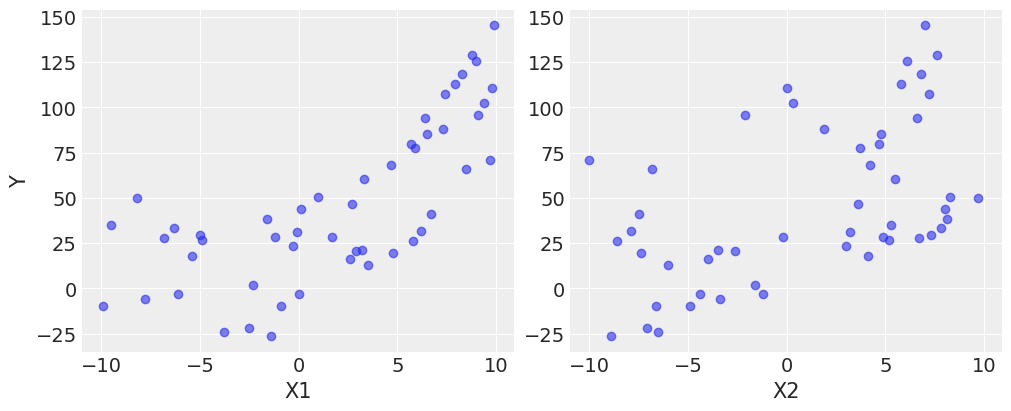

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(df['X1'], df['Y'], alpha=0.6)
axes[1].scatter(df['X2'], df['Y'], alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [5]:
with pm.Model() as model_1:
    inter = pm.Uniform('inter', lower=-25, upper=25)
    beta = pm.Normal('beta', mu=[10,0], sigma=2, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=2)

    mu = inter + beta[0]*df['X1'] + beta[1]*(df['X1']**2)

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['Y'])

    trace0 = pm.sample(idata_kwargs={'log_likelihood': True}, draws=2000, return_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter, beta, sigma]


Output()

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [6]:
az.summary(trace0, var_names=['inter', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inter,16.422,3.324,10.652,23.027,0.047,0.037,4824.0,3312.0,1.0
beta[0],4.787,0.407,4.008,5.532,0.005,0.005,5983.0,5057.0,1.0
beta[1],0.573,0.073,0.436,0.710,0.001,0.001,4858.0,4541.0,1.0
sigma,15.915,0.844,14.422,17.530,0.011,0.010,6374.0,4941.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'inter'}>,
        <Axes: title={'center': 'inter'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

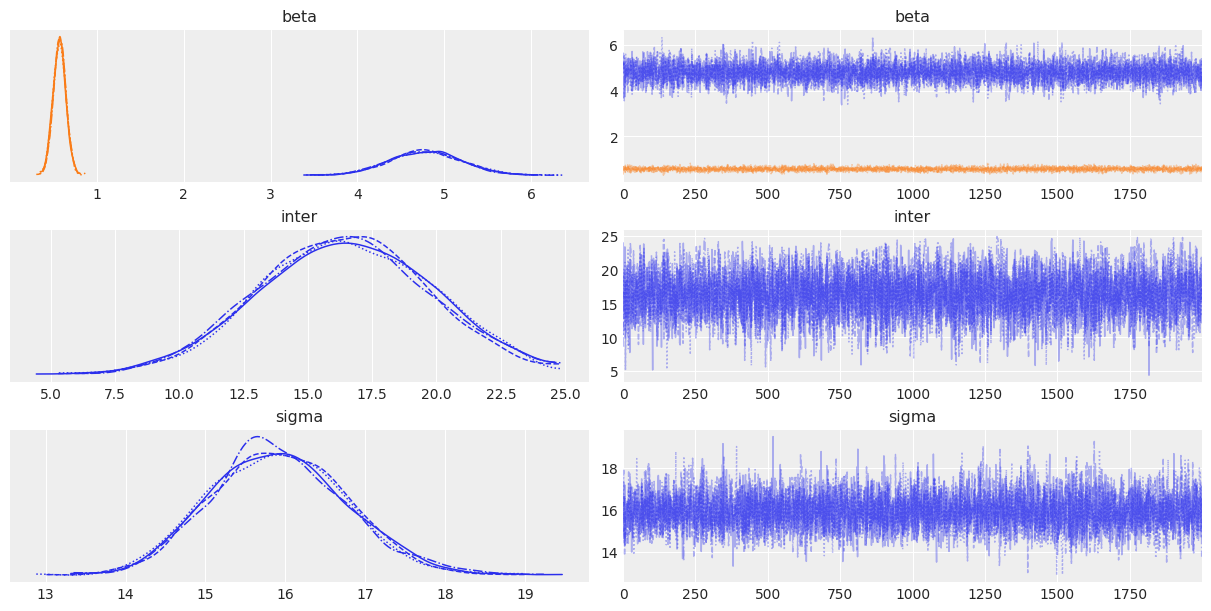

In [ ]:
az.plot_trace(trace0)
# Posterior Distribution for Model 1

Sampling: [y]


Output()

<Axes: xlabel='y'>

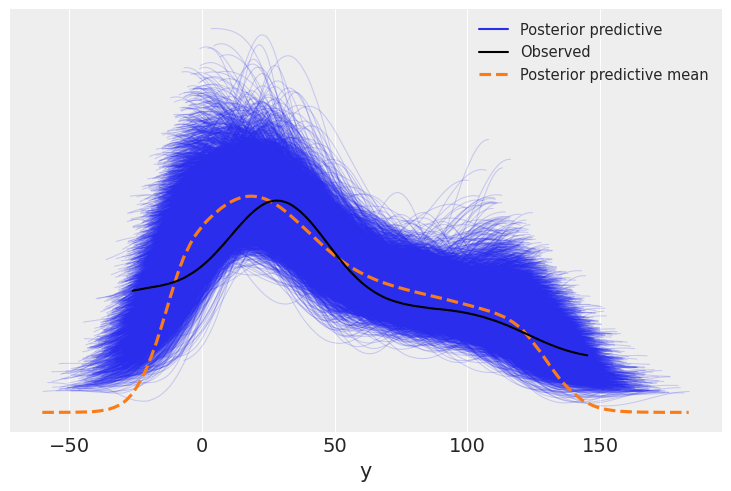

In [ ]:
with model_1:
    pm.sample_posterior_predictive(trace0, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace0)
# Posterior Predictive Check for Model 1

In [18]:
with pm.Model() as model_2:
    inter = pm.Uniform('inter', lower=-25, upper=25)
    beta = pm.Normal('beta', mu=2, sigma=2)
    sigma = pm.HalfNormal('sigma', sigma=2)

    mu = inter + beta*df['X2']

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['Y'])

    prior1 = pm.sample_prior_predictive(draws=50, random_seed=rng)
    trace1 = pm.sample(idata_kwargs={'log_likelihood': True}, draws=2000, return_inferencedata=True, random_seed=rng)

Sampling: [beta, inter, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [19]:
az.summary(trace1, var_names=['inter', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inter,24.476,0.517,23.534,25.000,0.006,0.009,5336.0,3824.0,1.0
beta,4.197,0.521,3.244,5.176,0.007,0.006,5858.0,5542.0,1.0
sigma,22.356,0.938,20.617,24.098,0.012,0.011,6580.0,4969.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'inter'}>,
        <Axes: title={'center': 'inter'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

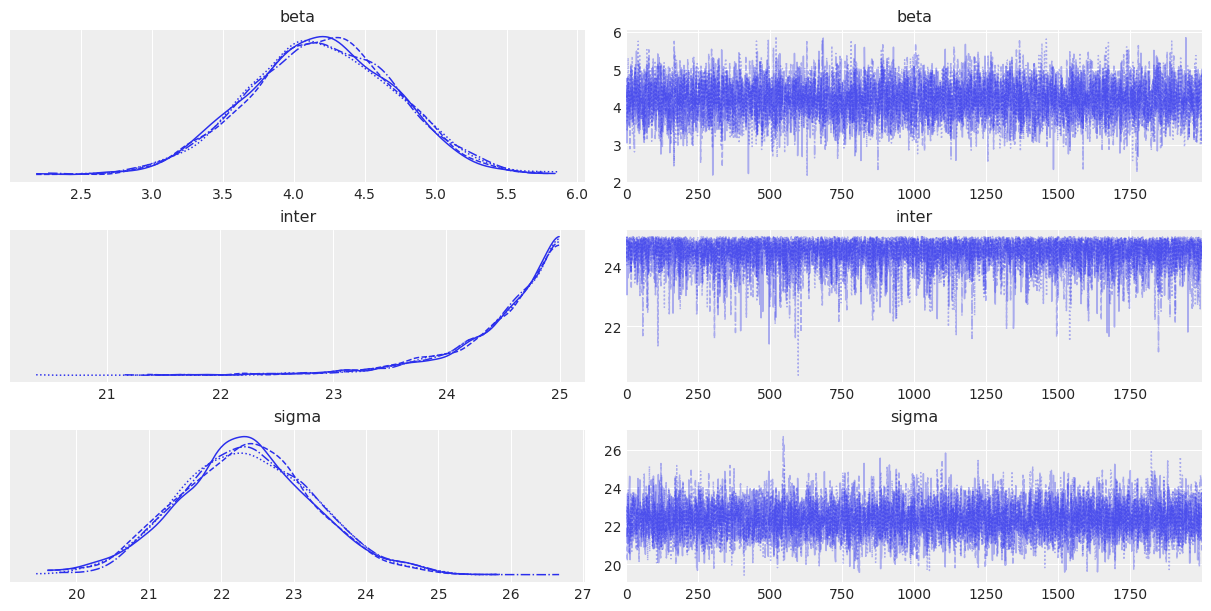

In [ ]:
az.plot_trace(trace1)
# Posterior Distribution for Model 2

Sampling: [y]


Output()

<Axes: xlabel='y'>

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


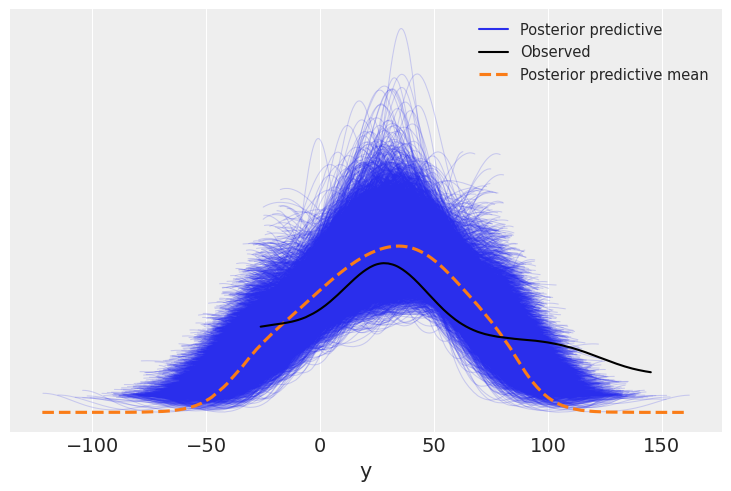

In [ ]:
with model_2:
    pm.sample_posterior_predictive(trace1, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace1)
# Posterior Predictive Check for Model 2

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

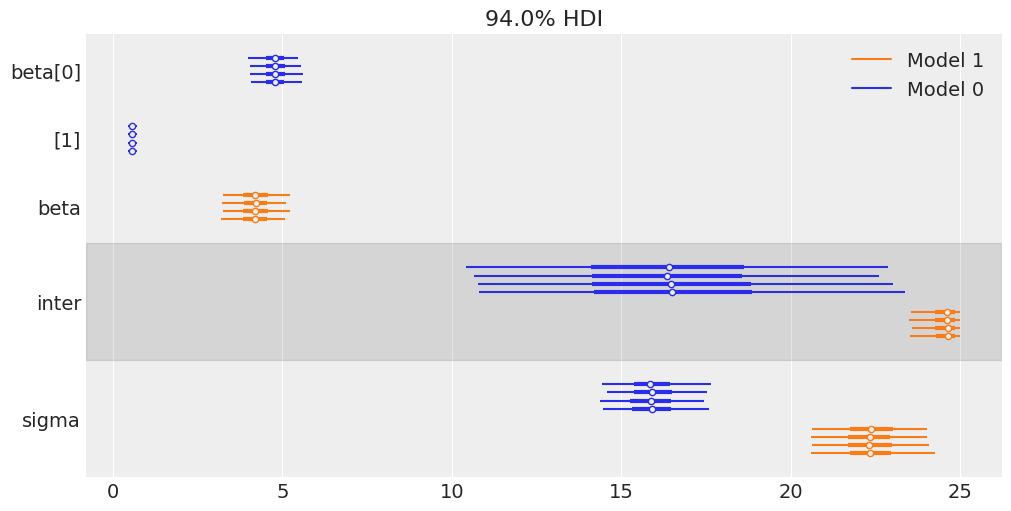

In [22]:
traces = [trace0, trace1]
az.plot_forest(traces, figsize=(10,5))

In [ ]:
model_dict = dict(zip(['only_x1', 'only_x2'], traces))
comp = az.compare(model_dict, method='stacking')
comp

# Weight of models using epdlc approximation using loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
only_x1,0,-244.666323,7.712297,0.000000,0.730208,7.020093,0.000000,False,log
only_x2,1,-291.527747,6.064277,46.861424,0.269792,17.408790,17.777814,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

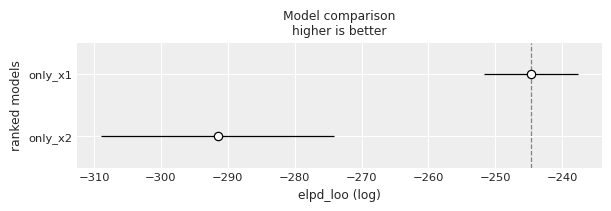

In [24]:
az.plot_compare(comp)

In [25]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)
ppc_w

Inference data with groups:
	> posterior_predictive
	> observed_data

<Axes: >

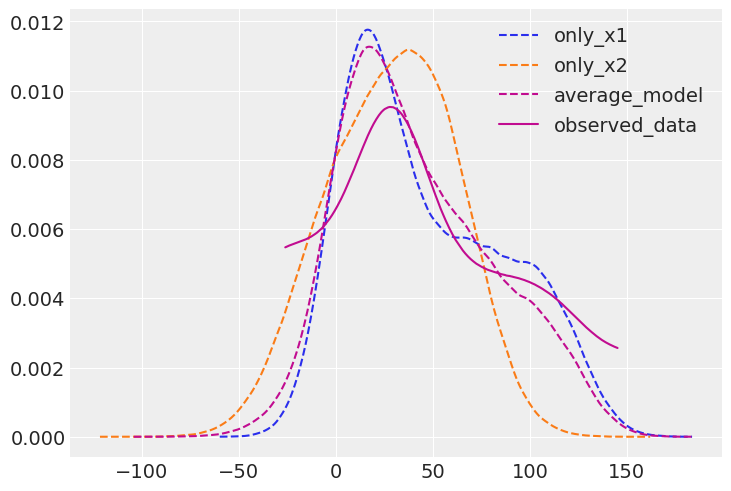

In [ ]:
az.plot_kde(
    trace0.posterior_predictive["y"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="only_x1",
)
az.plot_kde(
    trace1.posterior_predictive["y"].values,
    plot_kwargs={"color": "C1", "linestyle": "--"},
    label="only_x2",
)
az.plot_kde(
    ppc_w.posterior_predictive["y"].values,
    plot_kwargs={"color": "C3", "linestyle": '--'},
    label="average_model",
);
az.plot_kde(
    trace0.observed_data['y'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data"
)

#All models posterior prediction comparison